In [1]:
!pip install dwave-ocean-sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497 kB 8.1 MB/s 
     |████████████████████████████████| 966 kB 45.2 MB/s 
     |████████████████████████████████| 658 kB 45.3 MB/s 
     |████████████████████████████████| 110 kB 44.8 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 11.8 MB 41.9 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 
     |████████████████████████████████| 700 kB 67.8 MB/s 
     |████████████████████████████████| 5.3 MB 36.6 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 44 kB 1.4 MB/s 
     |████████████████████████████████| 246 kB 73.3 MB/s 


In [2]:
!git clone https://github.com/dwavesystems/dwave-ocean-sdk.git
!cd dwave-ocean-sdk
!python setup.py install

Cloning into 'dwave-ocean-sdk'...
remote: Enumerating objects: 4140, done.
remote: Counting objects: 100% (1156/1156), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 4140 (delta 908), reused 986 (delta 848), pack-reused 2984
Receiving objects: 100% (4140/4140), 13.15 MiB | 32.53 MiB/s, done.
Resolving deltas: 100% (2658/2658), done.
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [3]:
# set integers C
C = [2, 10, 3, 8, 5, 7, 9, 5, 3, 2]
N = len(C)

In [4]:
# set the above Q_{ii} & Q_{ij} as a dictionary type such as {(i, j): Q_{ij}}
Q = {}
for i in range(N):
    Q[i, i] = 4 * C[i] * (C[i] - sum(C))
    for j in range(i + 1, N):
        Q[i, j] = 8 * C[i] * C[j]

In [5]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

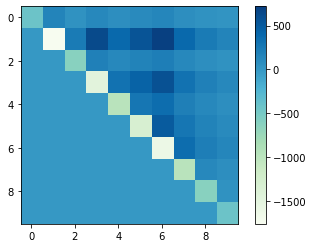

In [7]:
show_qubo(Q)

In [8]:
# set h_i & J_ij
h = {}
J = {}
for i in range(N):
    h[i] = 0
    for j in range(i + 1, N):
        J[i, j] = 2 * C[i] * C[j]

In [9]:
import dimod

In [10]:
# convert from ising model to QUBO
model = dimod.BinaryQuadraticModel(h, J, 0.0, vartype='SPIN')
qubo, offset = model.to_qubo()

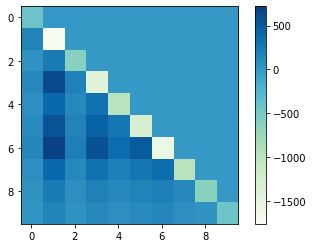

In [11]:
show_qubo(qubo)

# D-Wave 

In [14]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [16]:
# set the connection information as an option
endpoint = 'https://cloud.dwavesys.com/sapi'
token = 'DEV-'
solver = 'DW_2000Q_6'

# use DWaveSampler
dw = DWaveSampler(endpoint=endpoint, token=token, solver=solver)
# embed to Chimera graph
sampler = EmbeddingComposite(dw)

In [17]:
# in the case of ising model, use the following
response = sampler.sample_ising(h, J, num_reads=100)

# in the case of QUBO, use the following
# response = sampler.sample_qubo(Q, num_reads=100)

In [18]:
response.record

rec.array([([ 1,  1, -1, -1,  1, -1, -1,  1,  1, -1], -354., 2, 0.1),
           ([ 1, -1,  1,  1, -1,  1,  1, -1, -1,  1], -306., 1, 0.1),
           ([-1, -1,  1, -1, -1,  1,  1,  1, -1,  1], -366., 3, 0.1),
           ([ 1,  1, -1, -1,  1, -1, -1,  1, -1, -1], -270., 1, 0.1),
           ([-1, -1,  1, -1, -1,  1,  1,  1, -1, -1], -334., 1, 0.1),
           ([ 1, -1, -1,  1,  1, -1,  1, -1,  1, -1], -370., 1, 0. ),
           ([-1, -1, -1,  1,  1, -1,  1,  1, -1, -1], -370., 1, 0. ),
           ([-1,  1, -1, -1, -1, -1,  1,  1,  1, -1], -370., 1, 0. ),
           ([-1,  1,  1, -1,  1,  1, -1, -1, -1,  1], -370., 1, 0. ),
           ([-1, -1, -1,  1, -1, -1,  1,  1,  1,  1], -370., 1, 0. ),
           ([ 1, -1,  1,  1, -1, -1,  1,  1, -1, -1], -370., 1, 0. ),
           ([ 1, -1, -1,  1, -1, -1,  1,  1,  1, -1], -370., 1, 0. ),
           ([-1, -1, -1,  1, -1,  1,  1, -1,  1, -1], -370., 1, 0. ),
           ([ 1,  1, -1, -1,  1,  1, -1, -1,  1, -1], -370., 1, 0. ),
           ([ 1,  1,

In [19]:
def calcurate_energy(solution, vartype='BINARY'):
    if vartype == 'BINARY':
        ene = sum(C) ** 2  # offset
        for i in range(N):
            ene += Q[i, i] * solution[i]
            for j in range(i + 1, N):
                ene += Q[i, j] * solution[i] * solution[j]
    elif vartype == 'SPIN':
        ene = sum(C[i] ** 2 for i in range(N))
        for i in range(N):
            for j in range(i + 1, N):
                ene += J[i, j] * solution[i] * solution[j]
    else:
        raise ValueError("vartype mast be 'BINARY' or 'SPIN'.")

    return ene

In [20]:
# count the number of optimal solution
num_optimal_sol = 0
optimal_sol = []
twenty_sol = []
for state in response.record:
    # 0th contains a list of state, 2nd contains the number of occurrences in .record
    solution = state[0]
    num_oc = state[2]
    # compute energy
    energy = calcurate_energy(solution, vartype='SPIN')
    # count up the times when the energy is zero
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # preserve a result of 20 µs (we use later)
    twenty_sol.append(solution)

In [21]:
num_optimal_sol

10

In [22]:
for solution in optimal_sol:
    group_A = [C[i] for i, s in enumerate(solution) if s==1]
    group_B = [C[i] for i, s in enumerate(solution) if s==-1]
    print(solution)
    print('Group A: ', group_A, ', Sum = ', sum(group_A))
    print('Group B: ', group_B, ', Sum = ', sum(group_B))

[ 1 -1 -1  1  1 -1  1 -1  1 -1]
Group A:  [2, 8, 5, 9, 3] , Sum =  27
Group B:  [10, 3, 7, 5, 2] , Sum =  27
[-1 -1 -1  1  1 -1  1  1 -1 -1]
Group A:  [8, 5, 9, 5] , Sum =  27
Group B:  [2, 10, 3, 7, 3, 2] , Sum =  27
[-1  1 -1 -1 -1 -1  1  1  1 -1]
Group A:  [10, 9, 5, 3] , Sum =  27
Group B:  [2, 3, 8, 5, 7, 2] , Sum =  27
[-1  1  1 -1  1  1 -1 -1 -1  1]
Group A:  [10, 3, 5, 7, 2] , Sum =  27
Group B:  [2, 8, 9, 5, 3] , Sum =  27
[-1 -1 -1  1 -1 -1  1  1  1  1]
Group A:  [8, 9, 5, 3, 2] , Sum =  27
Group B:  [2, 10, 3, 5, 7] , Sum =  27
[ 1 -1  1  1 -1 -1  1  1 -1 -1]
Group A:  [2, 3, 8, 9, 5] , Sum =  27
Group B:  [10, 5, 7, 3, 2] , Sum =  27
[ 1 -1 -1  1 -1 -1  1  1  1 -1]
Group A:  [2, 8, 9, 5, 3] , Sum =  27
Group B:  [10, 3, 5, 7, 2] , Sum =  27
[-1 -1 -1  1 -1  1  1 -1  1 -1]
Group A:  [8, 7, 9, 3] , Sum =  27
Group B:  [2, 10, 3, 5, 5, 2] , Sum =  27
[ 1  1 -1 -1  1  1 -1 -1  1 -1]
Group A:  [2, 10, 5, 7, 3] , Sum =  27
Group B:  [3, 8, 9, 5, 2] , Sum =  27
[ 1  1 -1  1  1 -1 

In [23]:
response.data_vectors

{'energy': array([-354., -306., -366., -270., -334., -370., -370., -370., -370.,
        -370., -370., -370., -370., -370., -370., -366., -366., -366.,
        -366., -366., -366., -366., -366., -366., -366., -366., -366.,
        -366., -366.,  206., -354., -354., -354., -354., -354., -354.,
        -354., -354., -354., -354., -354., -354., -354., -354., -354.,
        -354., -354., -306., -306., -174., -334., -334., -334., -334.,
        -334., -334., -334., -334., -334., -334., -334.,  206.,  206.,
        -354., -354., -306., -306., -306., -306., -306., -334., -334.,
        -270., -270., -270., -226.,  206., -354., -306., -226.]),
 'num_occurrences': array([2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]),
 'chain_break_fraction': array([0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0

In [24]:
response.info

{'timing': {'qpu_sampling_time': 23894.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 198.4,
  'qpu_access_time': 34685.1,
  'qpu_access_overhead_time': 1445.9,
  'qpu_programming_time': 10791.1,
  'qpu_delay_time_per_sample': 20.54,
  'post_processing_overhead_time': 978.0,
  'total_post_processing_time': 978.0},
 'problem_id': '5c68de9c-987f-48a9-bb6c-0f0e07055d48'}

In [25]:
# in the case of ising model, use the following
response = sampler.sample_ising(h, J, num_reads=1000)

# in the case of QUBO, use the following
# response = sampler.sample_qubo(Q, num_reads=1000)

In [26]:
# count up the number of occurrences of optimal solution
num_optimal_sol = 0
optimal_sol = []
for state in response.record:
    # 0th is a list of states, 2nd is the number of occurrence in .record
    solution = state[0]
    num_oc = state[2]
    # compute energy
    energy = calcurate_energy(solution, vartype='SPIN')
    # count up the times when the energy is zero
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)

In [27]:
num_optimal_sol

136

In [28]:
response.info

{'timing': {'qpu_sampling_time': 238940.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 198.4,
  'qpu_access_time': 249731.9,
  'qpu_access_overhead_time': 1749.1,
  'qpu_programming_time': 10791.9,
  'qpu_delay_time_per_sample': 20.54,
  'post_processing_overhead_time': 3916.0,
  'total_post_processing_time': 3916.0},
 'problem_id': 'f52a50bf-ff6f-44cb-9309-b5cdf23ee213'}

In [29]:
# In the case of ising model, use the following
response = sampler.sample_ising(h, J, num_reads=100, annealing_time=50)

# In the case of QUBO, use the following
# response = sampler.sample_qubo(Q, num_reads=100, annealing_time=50)

In [30]:
# count up the number of times the optimal solution was found
num_optimal_sol = 0
optimal_sol = []
fifty_sol = []
for state in response.record:
    # 0th contains a list of states, 2nd contains the number of occurrences of states in .record
    solution = state[0]
    num_oc = state[2]
    # compute energy
    energy = calcurate_energy(solution, vartype='SPIN')
    # count up when the energy is 0
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # preserve a result of 50µs
    fifty_sol.append(solution)

In [31]:
num_optimal_sol

11

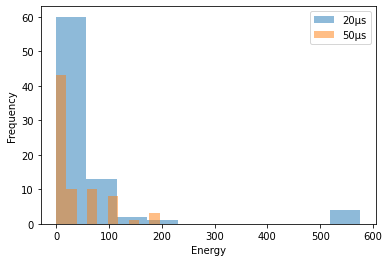

In [32]:
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in twenty_sol], alpha=0.5, label='20μs')
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in fifty_sol], alpha=0.5, label='50μs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()